In [1]:
import nltk
from nltk import FreqDist
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to C:\Users\Adil
[nltk_data]     Shagoo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
import pandas as pd
pd.set_option("display.max_colwidth",200)
import numpy as np
import re
import spacy
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df=pd.read_json("automotive_5.json",lines=True)
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B00002243X,"[4, 4]",5,I needed a set of jumper cables for my new car and these had good reviews and were at a good price. They have been used a few times already and do what they are supposed to - no complaints there....,"08 17, 2011",A3F73SC1LY51OO,Alan Montgomery,Work Well - Should Have Bought Longer Ones,1313539200
1,B00002243X,"[1, 1]",4,"These long cables work fine for my truck, but the quality seems a little on the shabby side. For the money I was not expecting 200 dollar snap-on jumper cables but these seem more like what you wo...","09 4, 2011",A20S66SKYXULG2,alphonse,Okay long cables,1315094400
2,B00002243X,"[0, 0]",5,"Can't comment much on these since they have not yet been used (I will come back and update my review is I find any issues after first use) ... but they are built solid, nice tough big hard clamps ...","07 25, 2013",A2I8LFSN2IS5EO,Chris,Looks and feels heavy Duty,1374710400
3,B00002243X,"[19, 19]",5,"I absolutley love Amazon!!! For the price of a set of cheap Booster/Jumper Cables in a brick and morter store, you can buy extra long and heavy duty jumpers! First off, don't be the person that ...","12 21, 2010",A3GT2EWQSO45ZG,DeusEx,Excellent choice for Jumper Cables!!!,1292889600
4,B00002243X,"[0, 0]",5,"I purchased the 12' feet long cable set and they arrived in a retail cardboard box with handle, which could be used as a storage and carrying case for these cables, although I will not need to sto...","07 4, 2012",A3ESWJPAVRPWB4,E. Hernandez,"Excellent, High Quality Starter Cables",1341360000


In [6]:
def freq_words(x,terms=30):
    all_words= " ".join([text for text in x])
    all_words=all_words.split()
    fdist= FreqDist(all_words)
    words_df=pd.DataFrame({"word":list(fdist.keys()),"count":list(fdist.values())})
    d=words_df.nlargest(columns="count",n =terms)
    plt.figure(figsize=(20,5))
    ax=sns.barplot(data=d , x="word",y = "count")
    ax.set(ylabel="count")
    plt.show()

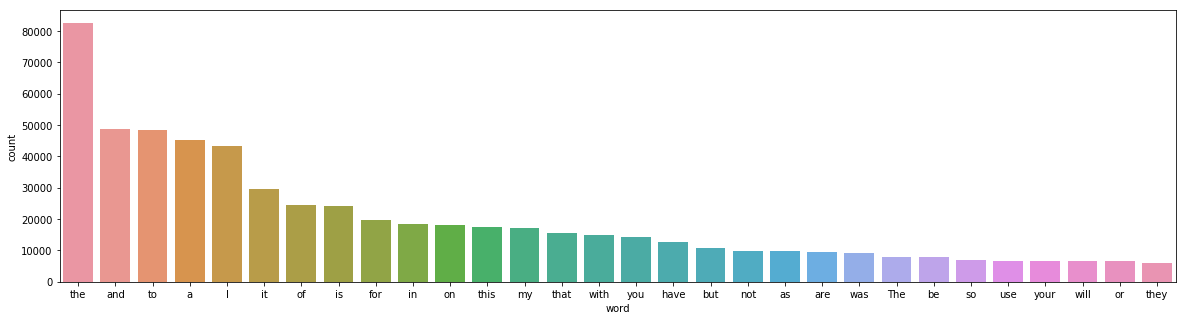

In [7]:
freq_words(df["reviewText"])

In [8]:
df['reviewText'] = df['reviewText'].str.replace("[^a-zA-Z#]", " ")

In [9]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [10]:
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

In [11]:
df['reviewText'] = df['reviewText'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

In [12]:
reviews = [remove_stopwords(r.split()) for r in df['reviewText']]

In [13]:
reviews = [r.lower() for r in reviews]

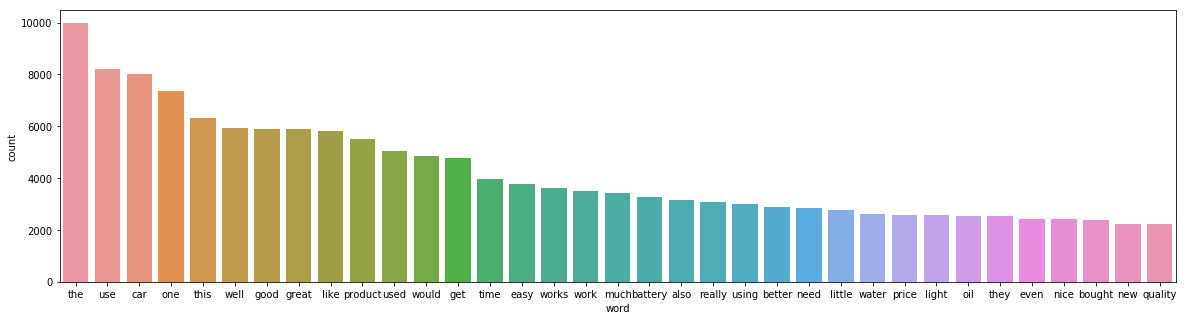

In [14]:
freq_words(reviews, 35)

In [22]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
       output = []
       for sent in texts:
             doc = nlp(" ".join(sent)) 
             output.append([token.lemma_ for token in doc if token.pos_ in tags])
       return output

In [23]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['these', 'long', 'cables', 'work', 'fine', 'truck', 'quality', 'seems', 'little', 'shabby', 'side', 'for', 'money', 'expecting', 'dollar', 'snap', 'jumper', 'cables', 'seem', 'like', 'would', 'see', 'chinese', 'knock', 'shop', 'like', 'harbor', 'freight', 'bucks']


In [24]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1]) # print lemmatized review

['long', 'cable', 'fine', 'truck', 'quality', 'little', 'shabby', 'side', 'money', 'dollar', 'jumper', 'cable', 'chinese', 'shop', 'harbor', 'freight', 'buck']


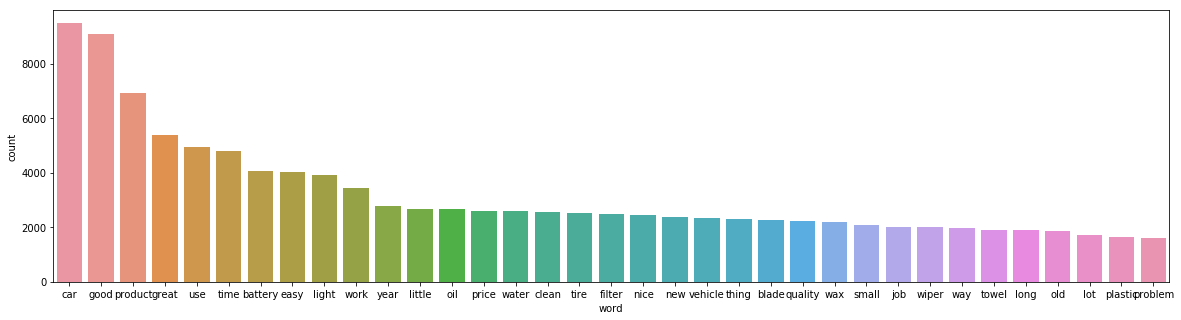

In [25]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

df['reviews'] = reviews_3

freq_words(df['reviews'], 35)

In [26]:
dictionary = corpora.Dictionary(reviews_2)

In [27]:
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

In [28]:
LDA = gensim.models.ldamodel.LdaModel
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=7, random_state=100,chunksize=1000, passes=50)

In [29]:
lda_model.print_topics()

[(0,
  '0.020*"oil" + 0.020*"good" + 0.015*"car" + 0.014*"filter" + 0.013*"product" + 0.010*"price" + 0.010*"engine" + 0.009*"change" + 0.009*"time" + 0.009*"water"'),
 (1,
  '0.055*"leather" + 0.039*"tire" + 0.038*"wheel" + 0.024*"clean" + 0.022*"seat" + 0.021*"brush" + 0.020*"mat" + 0.015*"smell" + 0.013*"product" + 0.013*"board"'),
 (2,
  '0.046*"car" + 0.034*"product" + 0.025*"towel" + 0.024*"good" + 0.016*"wax" + 0.015*"water" + 0.014*"use" + 0.014*"great" + 0.012*"time" + 0.012*"clean"'),
 (3,
  '0.051*"blade" + 0.042*"wiper" + 0.018*"windshield" + 0.015*"good" + 0.014*"rain" + 0.013*"car" + 0.011*"snow" + 0.011*"window" + 0.011*"year" + 0.010*"bosch"'),
 (4,
  '0.015*"good" + 0.013*"easy" + 0.012*"use" + 0.012*"hose" + 0.011*"great" + 0.010*"small" + 0.009*"work" + 0.009*"little" + 0.009*"nice" + 0.008*"plastic"'),
 (5,
  '0.064*"light" + 0.030*"bulb" + 0.020*"bright" + 0.014*"good" + 0.013*"white" + 0.012*"great" + 0.011*"headlight" + 0.010*"color" + 0.010*"easy" + 0.010*"insta

In [30]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

C:\Users\Adil Shagoo\AppData\Roaming\Python\Python36\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.073223 -0.031566       1        1  22.034983
2     -0.022152  0.063628       2        1  21.081884
0     -0.071841  0.096484       3        1  17.922050
6     -0.086894  0.210934       4        1  14.710140
5     -0.086405 -0.204967       5        1  10.349773
3     -0.060973 -0.131155       6        1   8.701227
1      0.401487 -0.003359       7        1   5.199951, topic_info=      Category         Freq         Term        Total  loglift  logprob
148    Default  4618.000000        light  4618.000000  30.0000  30.0000
955    Default  2420.000000        blade  2420.000000  29.0000  29.0000
39     Default  2989.000000      battery  2989.000000  28.0000  28.0000
2      Default  9553.000000          car  9553.000000  27.0000  27.0000
931    Default  2017.000000        wiper  2017.000000  26.0000  26.0000
337    Default  2087.000000         tire  2087.000000  25.0000  25.0000
1319   Default  1573.000000      leather  1573.000000  24.0000  24.0000
530    Default  2839.000000        towel  2839.000000  23.0000  23.0000
2586   Default  1670.000000         bulb  1670.000000  22.0000  22.0000
95     Default  2407.000000        clean  2407.000000  21.0000  21.0000
320    Default  6518.000000      product  6518.000000  20.0000  20.0000
169    Default  1921.000000          oil  1921.000000  19.0000  19.0000
722    Default  1090.000000        wheel  1090.000000  18.0000  18.0000
526    Default  1874.000000          wax  1874.000000  17.0000  17.0000
62     Default  1543.000000        power  1543.000000  16.0000  16.0000
1275   Default  1133.000000       bright  1133.000000  15.0000  15.0000
966    Default  1417.000000       filter  1417.000000  14.0000  14.0000
760    Default  1153.000000       device  1153.000000  13.0000  13.0000
930    Default   868.000000   windshield   868.000000  12.0000  12.0000
235    Default   788.000000         seat   788.000000  11.0000  11.0000
551    Default  1281.000000         wash  1281.000000  10.0000  10.0000
733    Default  1168.000000         unit  1168.000000   9.0000   9.0000
646    Default  1194.000000        paint  1194.000000   8.0000   8.0000
728    Default  1558.000000         hose  1558.000000   7.0000   7.0000
512    Default   595.000000        brush   595.000000   6.0000   6.0000
525    Default  2872.000000        water  2872.000000   5.0000   5.0000
529    Default  1091.000000   microfiber  1091.000000   4.0000   4.0000
604    Default   920.000000        white   920.000000   3.0000   3.0000
1745   Default  1082.000000        spray  1082.000000   2.0000   2.0000
1190   Default   866.000000      charger   866.000000   1.0000   1.0000
...        ...          ...          ...          ...      ...      ...
15853   Topic7    77.342140      bissell    78.066292   2.9472  -5.9058
2688    Topic7    72.893013      counter    73.611641   2.9467  -5.9650
6440    Topic7    72.424858         logo    73.146156   2.9466  -5.9715
2197    Topic7    70.474686       backup    71.195732   2.9463  -5.9988
2759    Topic7    65.521919   upholstery    66.239426   2.9456  -6.0717
4488    Topic7    64.155289     sunglass    64.876831   2.9453  -6.0927
2686    Topic7    63.646809         worn    64.366364   2.9453  -6.1007
2877    Topic7    63.123947         food    63.844261   2.9452  -6.1089
1053    Topic7    61.415798  convenience    62.139633   2.9448  -6.1364
473     Topic7   370.259247        board   418.330017   2.8345  -4.3398
235     Topic7   622.251282         seat   788.953369   2.7192  -3.8207
1406    Topic7   436.514252        smell   555.142029   2.7161  -4.1752
1062    Topic7   178.285431      kitchen   203.746414   2.8230  -5.0707
1243    Topic7   117.260086         boot   132.944260   2.8310  -5.4896
337     Topic7  1110.224487         tire  2087.357178   2.3252  -3.2417
1544    Topic7   330.998627        brake   497.410217   2.5492  -4.4519
1980    Topic7 